Developted using tutorial by Imad Pasha
https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html

Other sources:
https://arxiv.org/abs/1008.4686 (David Hogg)

https://arxiv.org/abs/1710.06068 (Hogg, Foreman-Mackey)

In [3]:
from astropy.io import ascii
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import emcee
import corner

In [4]:
data = pd.read_csv('./de_souza_sample.csv')

In [5]:
def model(theta, x_data):
    """Model for exponential family regression.
    
    Takes a given theta vector as input and returns the model evaluated at that theta.

    Args:
        theta : array_like (float)
                Vector defining params beta_0 and beta_1 for linear predictor
        x_data : array_like (float)
                 Array of measured x values

    Returns
        model : array_like (float)
                Array of y values for the given model parameters and x values


    """

    b0, b1 = theta
    model = np.exp(b0 + (b1 * x_data))
    return model

In [6]:
def log_likelihood(theta, x_data, y_data, y_data_err):
    """Determines the log likelihood for a given model and data.
    
    Takes a given theta vector, x data, y and y error data as inputs 
    and returns the log likelihood of the model given the data.

    Args:
        theta : array_like (float)
                Vector defining params beta_0 and beta_1 for linear predictor
        x_data : array_like (float)
                 Array of measured x values
        y_data : array_like (float)
                 Array of measured y values
        y_data_err : array_like (float)
                     Array of measured y error values                

    Returns
        log_like : array_like (float)
                Array of log likelihoods for the given model parameters and data values


    """    
    y_model = model(theta, x_data)
    log_like = -0.5 * np.sum(((y_data - y_model) / y_data_err)**2)
    
    return log_like

In [7]:
def log_prior(theta):
    """Deterines whether the selected theta values are within the allowed bounds.
    
    Args:
        theta : array-like (float)
                Vector defining params beta_0 and beta_1 for linear predictor

    Returns:
        0.0 if all parameters are within the allowed values, -np.inf if not
    """
    b0, b1 = theta

    #if #condition:
    #    return 0.0
    #else:
    #    return -np.inf

    #No conditions on beta0 and beta1 for this case
    return 0.0

In [8]:
def log_prob(theta, x_data, y_data, y_data_err):
    """Determines the log probability for a given model and data.
    
    Takes a given theta vector, x data, y and y error data as inputs 
    and returns the log probability of the model given the data.

    Args:
        theta : array_like (float)
                Vector defining params beta_0 and beta_1 for linear predictor
        x_data : array_like (float)
                 Array of measured x values
        y_data : array_like (float)
                 Array of measured y values
        y_data_err : array_like (float)
                     Array of measured y error values                

    Returns
        log_like : array_like (float)
                Array of log likelihoods for the given model parameters and data values


    """    
    lp = log_prior(theta)
    #convention to be able to weed out bad combiinations of theta, but all thetas are allowed so this is redundant

    return lp + log_likelihood(theta, x_data, y_data, y_data_err)

From the MCMC tutorial:

*2020 Update: Foreman-Mackey & Hogg recommend that in many cases, running an optimizer first (e.g., from scipy) is the best way to select an initial starting value. [for theta]

I'm not sure how to do this, so what I'm going to do for now is draw b0 and b2 from normal distributions with mean=0 and loc=1e6, since these are the uninformative priors placed on those parameters in the de Souza paper

In [9]:
#create tuple of data
mbh_data = np.array(data['logMB'])
ngc_data = np.array(data['NGC'])
ngc_err_data = np.array(data['NGC_err'])
input_data = (mbh_data, ngc_data, ngc_err_data)

In [10]:
#set number of walkers for the MCMC
n_walkers = 500
#set number of iterations for the MCMC
n_iter = 50000
#set the initial guess for the parameters
b0, b1 = np.random.normal(0, 1e-6, 2)
#the values in dhe de Souza results are centered around B0 = -6 and B1 = 1.5, so i'll try using those for an initial guess
initial = np.array([-6.0, 1.5])
n_dim = len(initial)

#stepping methodology (taken from MCMC tutorial )
p0 = [np.array(initial) + 1e-7 * np.random.randn(n_dim) for i in range(n_walkers)]

In [11]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    #code to run the MCMC, copied from tutorial and adapted for this exercise
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [12]:
sampler, pos, prob, state = main(p0,n_walkers,n_iter,n_dim,log_prob,input_data)

Running burn-in...
Running production...


In [13]:
data.head(1)

,Name,VMag,VMag_err,NGC,NGC_err,sigma,sigma_err,logMd,logMB,logMB_err_hi,logMB_err_lo
0,MilkyWay,-21.3,0.3,160.0,10.0,105.0,20.0,9.856,6.61,0.04,0.04


In [14]:
mbh_err_data = np.array((data['logMB_err_hi'] + data['logMB_err_lo']) / 2)

In [15]:
len(mbh_err_data)

45

In [16]:
def plotter(sampler,x=mbh_data,y=ngc_data, xerr=mbh_err_data, yerr=ngc_err_data):
    plt.ion()
    plt.errorbar(x, y, yerr=yerr, xerr=xerr, fmt='none',label='de Souza Sample', capsize=1, zorder=10)
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        order = np.argsort(x)
        plt.plot(x[order], model(theta, x[order]), color="r", alpha=0.1)

    plt.yscale('log')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('$log(M_{BH})$')
    plt.ylabel(r'$N_{GC}$')
    plt.legend()
    plt.show()


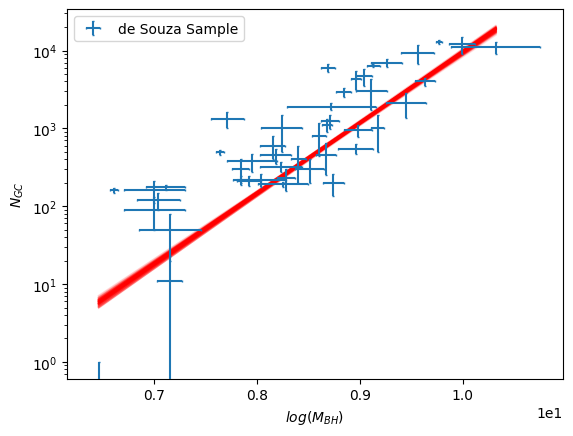

In [17]:
plotter(sampler)

In [19]:
samples = sampler.flatchain
theta_max = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max, mbh_data)

In [21]:
def sample_walkers(nsamples,flattened_chain, x_data):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i, x_data)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,samples, mbh_data)

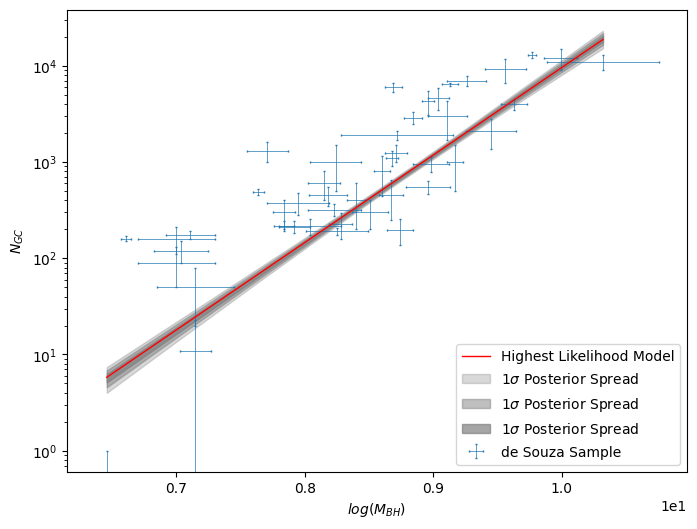

In [33]:
plt.figure(figsize=(8,6))
order = np.argsort(mbh_data)

plt.errorbar(mbh_data, ngc_data, yerr=ngc_err_data, xerr=mbh_err_data, lw=0.5, fmt='none',label='de Souza Sample', capsize=1)
plt.plot(mbh_data[order],best_fit_model[order], color='red', lw=1, label='Highest Likelihood Model')
plt.fill_between(mbh_data[order],med_model[order]-3*spread[order],med_model[order]+3*spread[order],color='grey',alpha=0.3,label=r'$1\sigma$ Posterior Spread')
plt.fill_between(mbh_data[order],med_model[order]-2*spread[order],med_model[order]+2*spread[order],color='grey',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
plt.fill_between(mbh_data[order],med_model[order]-spread[order],med_model[order]+spread[order],color='grey',alpha=0.7,label=r'$1\sigma$ Posterior Spread')
plt.legend()

plt.yscale('log')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('$log(M_{BH})$')
plt.ylabel(r'$N_{GC}$')
plt.legend();